In [3]:
import pandas as pd
import unicodedata
import matplotlib.pyplot as plt

file_path = "INMET_SE_SP_A701_SAO PAULO - MIRANTE_01-01-2025_A_31-07-2025.CSV"

# Ler CSV tirando as primeiras 8 linhas de cabeçalho
df = pd.read_csv(file_path, sep=";", encoding="utf-8", skiprows=8)

df.columns = [
    unicodedata.normalize("NFKD", col)
    .encode("ASCII", "ignore")
    .decode("utf-8")
    .strip()
    for col in df.columns
]

# Renomear colunas principais
renomear = {
    "data": ["Data"],
    "hora_utc": ["Hora UTC"],
    "chuva_mm": ["PRECIPITACAO TOTAL, HORARIO (mm)",
                 "PRECIPITAO TOTAL, HORRIO (mm)"],
    "temp_c": ["TEMPERATURA DO AR - BULBO SECO, HORARIA (C)"],
    "umidade": ["UMIDADE RELATIVA DO AR, HORARIA (%)"]
}

# Criar mapeamento dinâmico
col_map = {}
for novo, antigos in renomear.items():
    for old in antigos:
        if old in df.columns:
            col_map[old] = novo

df = df.rename(columns=col_map)

df["datetime"] = pd.to_datetime(
    df["data"] + " " + df["hora_utc"],
    format="%Y/%m/%d %H%M UTC",
    errors="coerce"
)

# Converter numéricos (corrigir vírgula decimal)
for col in ["chuva_mm", "temp_c", "umidade"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(",", ".").astype(float)

df["mes"] = df["datetime"].dt.month
df["ano"] = df["datetime"].dt.year

# Resumo diário para um mês escolhido
def resumo_diario(mes_escolhido):
    df_mes = df[df["mes"] == mes_escolhido]
    if df_mes.empty:
        return f"Nenhum dado disponível para o mês {mes_escolhido}."
    df_daily = df_mes.groupby(df_mes["datetime"].dt.date).agg({
        "chuva_mm": "sum" if "chuva_mm" in df_mes else "first",
        "temp_c": "mean" if "temp_c" in df_mes else "first",
        "umidade": "mean" if "umidade" in df_mes else "first"
    }).reset_index().rename(columns={"datetime": "dia"})
    return df_daily

mes_escolhido = int(input("Digite o número do mês para o resumo diário: "))

print("\nResumo diário:")
print(resumo_diario(mes_escolhido))

# Resumo mensal até o último mês disponível
df["mes_ano"] = df["datetime"].dt.to_period("M")
df_monthly = df.groupby("mes_ano").agg({
    "chuva_mm": "sum" if "chuva_mm" in df else "first",
    "temp_c": "mean" if "temp_c" in df else "first",
    "umidade": "mean" if "umidade" in df else "first"
}).reset_index()

print("\nResumo mensal:")
print(df_monthly)




Resumo diário:
           dia  chuva_mm     temp_c    umidade
0   2025-03-01       0.0  25.970833  60.291667
1   2025-03-02       0.0  26.470833  57.625000
2   2025-03-03       0.0  25.554167  59.375000
3   2025-03-04       0.0  24.929167  60.541667
4   2025-03-05       0.0  24.800000  62.708333
5   2025-03-06       0.0  24.183333  63.416667
6   2025-03-07       0.0  24.200000  61.000000
7   2025-03-08       0.0  24.187500  64.583333
8   2025-03-09       0.0  25.445833  59.916667
9   2025-03-10       0.4  24.283333  62.666667
10  2025-03-11       8.6  23.586957  70.173913
11  2025-03-12       8.2  23.291667  75.458333
12  2025-03-13      14.4  23.883333  73.375000
13  2025-03-14       0.0  23.766667  72.208333
14  2025-03-15       0.0  23.317391  69.913043
15  2025-03-16       0.0  21.279167  78.375000
16  2025-03-17       0.0  22.191667  73.875000
17  2025-03-18      20.2  22.778261  74.304348
18  2025-03-19      25.2  20.941667  80.708333
19  2025-03-20       0.4  20.395652  73.0434

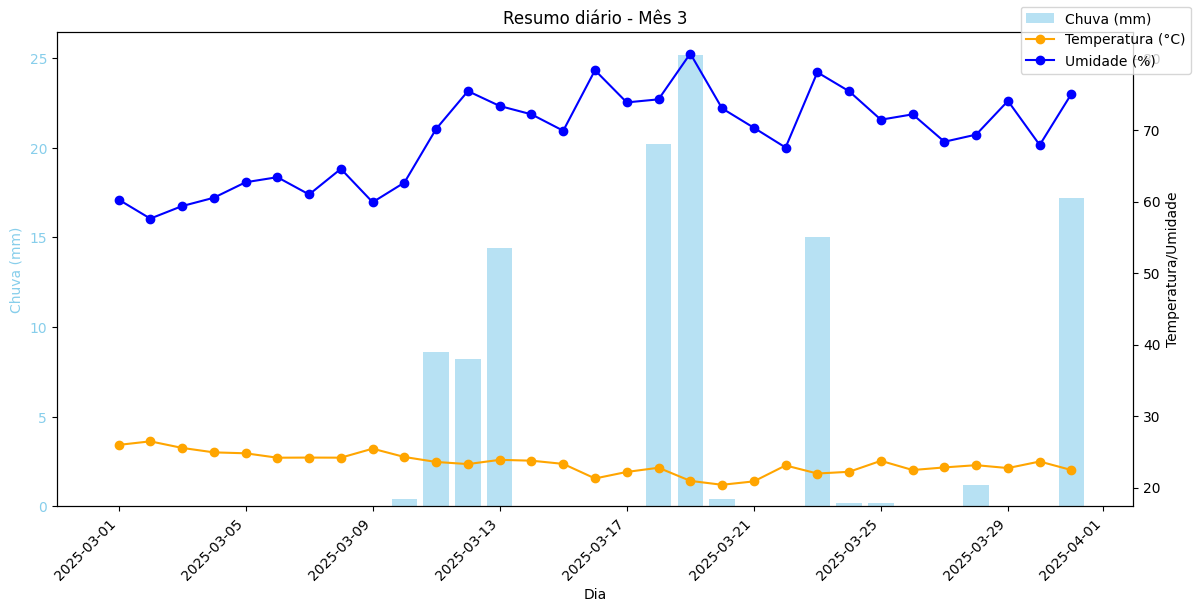

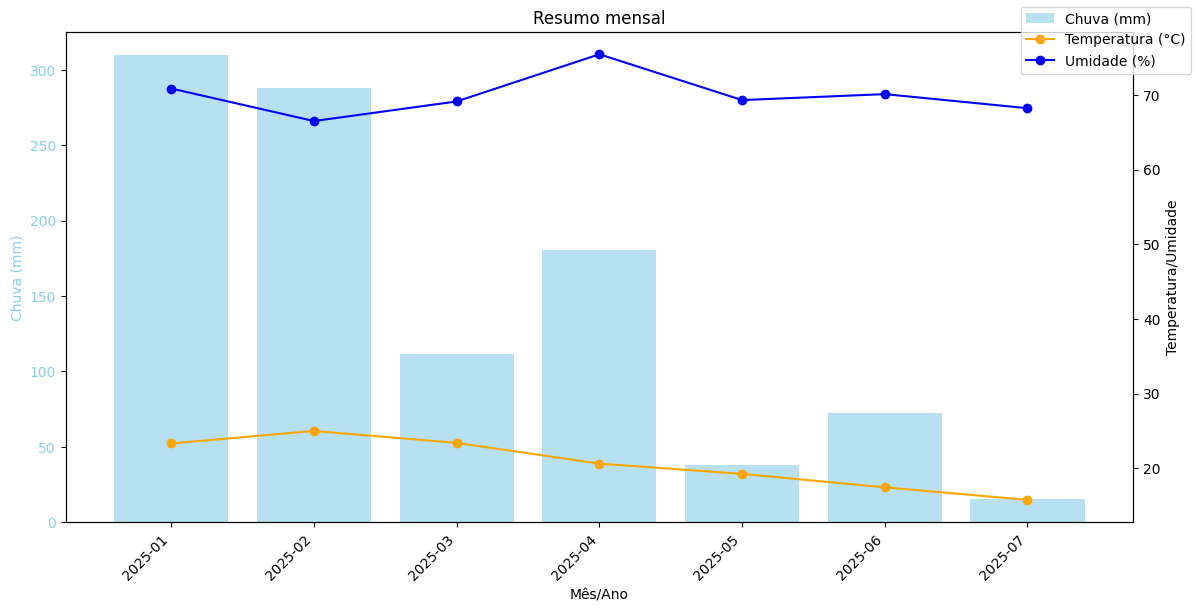

In [5]:
deseja_grafico = input("\nDeseja ver os gráficos dos resumos apresentados? ")

if deseja_grafico.lower() == "sim":
    # Gráfico do resumo diário
    df_daily = resumo_diario(mes_escolhido)
    if not df_daily.empty:
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Barras de chuva
        ax1.bar(df_daily["dia"], df_daily["chuva_mm"], color="skyblue", alpha=0.6, label="Chuva (mm)")
        ax1.set_xlabel("Dia")
        ax1.set_ylabel("Chuva (mm)", color="skyblue")
        ax1.tick_params(axis='y', labelcolor="skyblue")

        # Linhas de temperatura e umidade
        ax2 = ax1.twinx()
        ax2.plot(df_daily["dia"], df_daily["temp_c"], color="orange", marker="o", label="Temperatura (°C)")
        ax2.plot(df_daily["dia"], df_daily["umidade"], color="blue", marker="o", label="Umidade (%)")
        ax2.set_ylabel("Temperatura/Umidade", color="black")

        fig.autofmt_xdate(rotation=45)
        fig.tight_layout()
        fig.legend(loc="upper right")
        plt.title(f"Resumo diário - Mês {mes_escolhido}")
        plt.show()

    # Gráfico resumo mensal
    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.bar(df_monthly["mes_ano"].astype(str), df_monthly["chuva_mm"], color="skyblue", alpha=0.6, label="Chuva (mm)")
    ax1.set_xlabel("Mês/Ano")
    ax1.set_ylabel("Chuva (mm)", color="skyblue")
    ax1.tick_params(axis='y', labelcolor="skyblue")

    ax2 = ax1.twinx()
    ax2.plot(df_monthly["mes_ano"].astype(str), df_monthly["temp_c"], color="orange", marker="o", label="Temperatura (°C)")
    ax2.plot(df_monthly["mes_ano"].astype(str), df_monthly["umidade"], color="blue", marker="o", label="Umidade (%)")
    ax2.set_ylabel("Temperatura/Umidade", color="black")

    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()
    fig.legend(loc="upper right")
    plt.title("Resumo mensal")
    plt.show()
else:
    print("Saindo...")
